## Analysis of the full glycolysis network - Glucose substrate - OED
#### Experiment code : SNMS37

In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns; sns.set_theme(style='ticks', context='paper')
import colorcet as cc
import glob

import toml

In [2]:
#Definition of constants
TIMEBIN = 150 #Binning (~80s) - The noise level of this experiment was much higher, we thus increase the binning
#The level of noise is not inherent to the experiment, it arises because 10x more concentration of glutamate was added
#The determination of the flow ratios creates more noise because we compare two very different intensities when comparing glutamate and 15N-glutamate

### Isotopic ratios for isotopic correction (15N-Glu, NADH) ###
Glu_13C_isotope = 0.0546 # Percentage of signal of glutamate isotope (146) to remove from 15N-glutamate (147)
NAD_2_13C_isotope = 0.0245 # Percentage of signal of NAD isotope (662) to remove from NADH (664)
Glu_conc_ratio = 0.104429302*10 #Ratio of concentrations of glutamate (0.05517 mM) and 15N-glutamate (0.5283 mM)
# !!! By mistake, 10x the usual concentration of glutamate was added !!!

### NMR concentrations ###
F_concentration = 0.09288 # mM
G_concentration = 0.07956 # mM
G6P_concentration = 0.08957 # mM
F6P_concentration = 0.07707 # mM
FBP_concentration = 0.05594 # mM
ATP_concentration = 0.05 # mM
Pyr_concentration = 0.0912 # mM
Lac_concentration = 0.096288 # mM
PG_concentration = 0.088709 # mM
PEP_concentration = 0.09325 # mM

### Frag ratios ###
FBPtoF6P = 0.071
FtoLac = 0.058
GtoLac = 0.038

## Reading the data and conditions

In [3]:
#Reading the conditions
flow_parameters = toml.load("conditions/SNMS37_flowparameters.toml")
inputs = np.array([[c['length'], c['syringe_parameters']['G']['reactor_concentration'], 
                    c['syringe_parameters']['ATP']['reactor_concentration'], 
                    c['syringe_parameters']['ADP']['reactor_concentration'], 
                    c['syringe_parameters']['NAD']['reactor_concentration']] 
                    for c in flow_parameters['sections']
                ])

df_inputs = pd.DataFrame(
        inputs, columns=['time', 'G', 'ATP', 'ADP', 'NAD']
    ).assign(time = np.cumsum(inputs[:,0]))
#print(df_inputs)

In [4]:
#Reading the data
files = pathlib.Path(f"data/SNMS37/").glob('*.xy')

sumdf = pd.DataFrame()
    
try:
    with open(f"data/SNMS37/TIC.xy",'r') as fin:
        df = pd.read_csv(fin, sep=' ', names=['Time','TIC'])
        df_TICSamp1 = df['Time'].groupby(df.index // TIMEBIN).min()
        df_TICSamp2 = df['TIC'].groupby(df.index // TIMEBIN).sum()
        df_TICSamp = pd.concat([df_TICSamp1,df_TICSamp2], axis=1)
                    
except FileNotFoundError:
    print("No TIC files here!")
    
df_Time = df_TICSamp['Time']

sumdf["retention_time"] = df_Time
        
fileList=glob.glob(f"data/SNMS37/*.xy")
fileList.remove(f"data/SNMS37\\TIC.xy")
    
for file in fileList:
    try:
        with open(file,'r') as fin:
            df_file = pd.read_csv(fin, sep=' ', names=['Time','IC'])

            ionname = pathlib.Path(file).stem
            
            #binning
            df_Samp1 = df_file['Time'].groupby(df_file.index // TIMEBIN).min()
            df_Samp2 = df_file['IC'].groupby(df_file.index // TIMEBIN).sum()
            df_Samp = pd.concat([df_Samp1,df_Samp2], axis=1)

            #TIC corr
            df_SampTIC = df_Samp['IC'] / df_TICSamp['TIC']
            df_SampTIC.name = ionname

            sumdf[ionname] = df_SampTIC
    except FileNotFoundError:
        print("Missing files")

    
sumdf = sumdf.assign(retention_time = sumdf.retention_time.round(1))
sumdf = sumdf.set_index('retention_time')
#print(sumdf)

In [5]:
#Calculation of the flow ratios between dilution line and reactor
sumdf["Flow ratio"] = ((sumdf["L_Glu"] - (Glu_13C_isotope*sumdf["Glu"]))/(sumdf["Glu"]))*(Glu_conc_ratio)
sumdf["Flow ratio"].replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0

### Getting the metabolite concentrations

(3600.0, 54000.0)

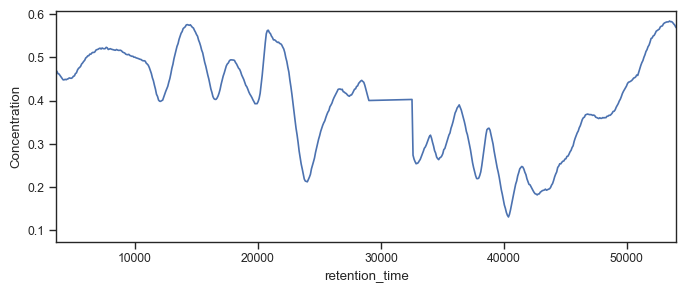

In [6]:
# NADH readout with UV
# Funny detail : The experiment was recorded during a night when we changed from Summer to Winter time (Daylight savings time)
# Because of changing hours between 2 am and 3am, the data after 28699.249s were erased during the measurement ... 
# We will thus add 1h to the time after the point 5194

NADH_df = pd.read_csv("data/SNMS37_UV.dat", header=8, delim_whitespace=True, decimal=",")
NADH_df.columns = ["StdTime", "Time", "Value"]

NADH_df["Concentration"] = (3340.1-0.0138*NADH_df["Value"].values)*0.001 # mM - From UV cell calibration

NADH_df.loc[5194:,"Time"] = NADH_df["Time"] + 3600
NADH_df.index = NADH_df["Time"] + 300 #offset
NADH_df = NADH_df.drop(columns=["StdTime", "Time"])

desired_index = sumdf.index
NADH_df = NADH_df.reindex(NADH_df.index.union(desired_index)).interpolate(method='linear').reindex(desired_index)

fig, ax = plt.subplots(figsize=(8, 3))
sns.lineplot(NADH_df["Concentration"])
ax.set_xlim(3600,54000)

C:\Users\qduez\AppData\Local\Temp\ipykernel_12384\609233755.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputs, x="time", y="G", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="G", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_12384\609233755.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputs, x="time", y="ATP", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="ATP", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_12384\609233755.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputs, x="time", y="NAD", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="NAD", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_12384\609233755.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = d

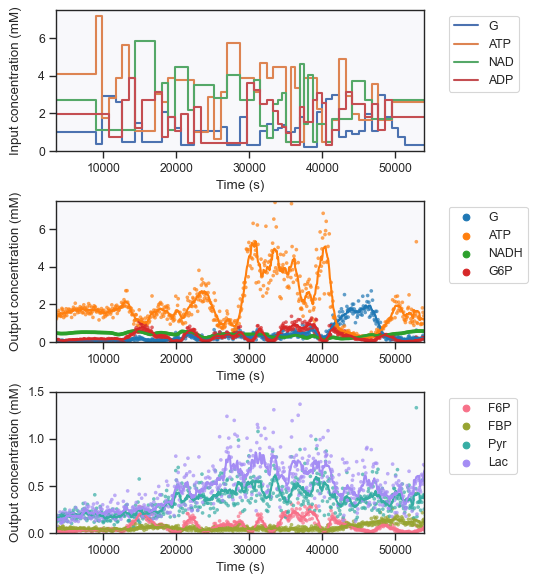

In [7]:
quantif_df1 = pd.DataFrame()
quantif_df2 = pd.DataFrame()

quantif_df1.index = sumdf.index
quantif_df2.index = sumdf.index

quantif_df1['G'] = (sumdf['L_G'] / sumdf['G'])*(G_concentration / sumdf["Flow ratio"])
quantif_df1['ATP'] = (sumdf['ATP_2+'] / sumdf['L_ATP_2+'])*(ATP_concentration / sumdf["Flow ratio"])
quantif_df1['NADH'] = NADH_df["Concentration"]
quantif_df1['G6P'] = (sumdf['L_G6P'] / sumdf['G6P'])*(G6P_concentration / sumdf["Flow ratio"])
quantif_df2['F6P'] = ((sumdf['L_F6P'] - (FBPtoF6P*sumdf['L_FBP'])) / (sumdf['F6P'] - (FBPtoF6P*sumdf['FBP'])))*(F6P_concentration / sumdf["Flow ratio"]) #With FBP to F6P correction
quantif_df2['FBP'] = (sumdf['L_FBP'] / sumdf['FBP'])*(FBP_concentration / sumdf["Flow ratio"])
quantif_df2['Pyr'] = (sumdf['L_Pyr'] / sumdf['13C_Pyr'])*(Pyr_concentration / sumdf["Flow ratio"])
quantif_df2['Lac'] = ((sumdf['L_Lac'] - (GtoLac*sumdf['L_G'])) / (sumdf['Lac'] - (GtoLac*sumdf['G'])))*(Lac_concentration / sumdf["Flow ratio"]) #With correction of F to Lac fragmentation
quantif_df1.replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0
quantif_df2.replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0

rolled_df1 = quantif_df1.rolling(10, center=True).mean()
rolled_df2 = quantif_df2.rolling(10, center=True).mean()

fig, ax = plt.subplots(3,1)

sns.lineplot(data = df_inputs, x="time", y="G", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="G", palette="tab10")
sns.lineplot(data = df_inputs, x="time", y="ATP", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="ATP", palette="tab10")
sns.lineplot(data = df_inputs, x="time", y="NAD", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="NAD", palette="tab10")
sns.lineplot(data = df_inputs, x="time", y="ADP", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="ADP", palette="tab10")

sns.scatterplot(quantif_df1, alpha=0.7, ax=ax[1],  markers=["o"], s=7, palette="tab10", linewidth=0)
sns.lineplot(rolled_df1, dashes=False, alpha=1, ax=ax[1], linewidth=1.5, legend=None, palette="tab10")
sns.scatterplot(quantif_df2, alpha=0.7, ax=ax[2],  markers=["o"], s=7, palette="husl", linewidth=0)
sns.lineplot(rolled_df2, dashes=False, alpha=1, ax=ax[2], linewidth=1.5, legend=None, palette="husl")

ax[0].set_xlim(3600,54000)
ax[0].set_ylim(0,7.5)
ax[1].set_xlim(3600,54000)
ax[1].set_ylim(0,7.5)
ax[2].set_xlim(3600,54000)
ax[2].set_ylim(0,1.5)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Input concentration (mM)")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Output concentration (mM)")
ax[2].set_xlabel("Time (s)")
ax[2].set_ylabel("Output concentration (mM)")

fig.align_ylabels(ax[:])
ax[0].set_facecolor('#F8F8FB')
ax[1].set_facecolor('#F8F8FB')
ax[2].set_facecolor('#F8F8FB')

ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplots_adjust(left=None, bottom=None, right=0.7, top=1.2, wspace=None, hspace=0.35)